# Модель предсказания размера и периодичности взносов участников НПО

Описание: В течение многих столетий доля пожилых людей старше 60 лет не превышала 10% от общего числа людей. Однако, с развитием промышленности, технологий, повышением качества здравоохранения, по прогнозам демографов доля пожилого населения может достигнуть 30% к середине столетия, а медианный возраст населения развитых стран достигнет 55 лет. В связи с этим становится актуальной проблема благополучия пожилых людей. Программы негосударственного пенсионного обеспечения (НПО) предоставляют возможность формирования дополнительного пенсионного капитала.

Участникам предлагается разработать прототип сервиса прогнозирования размера и периодичности взносов участников НПО, с акцентом на интерпретируемость с точки зрения использованных (сгенерированных) данных. Понимание факторов, влияющих на изменение финансового поведения участников, является важным как с точки зрения государства, так и нашей компании.

В представленном архиве вы можете увидеть три файла следующего содержания.
1. Файл *npo_clnts.csv* содержит информацию о клиентах НПО, а именно следующие поля:
	- **clnt_id** - ID клиента
	- **slctn_nmbr** - Номер выборки
	- **gndr** - Пол клиента: "м": "0", "ж": "1"
	- **age** - Возраст клиента, лет
	- **brth_yr** - Год рождения клиента
	- **pstl_code** - Почтовый индекс
	- **city** - Живет клиент в городе (1) или нет (0)
2. Файл *npo_cntrbtrs.csv* содержит информацию о статусах счетов клиентов НПО, а именно следующие поля:
	- **npo_accnt_id** - ID счета клиента
	- **client_id** - ID клиента
	- **slctn_nmbr** - Номер выборки
	- **accnt_pnsn_schm** - Условный код пенсионной схемы счета клиента
	- **npo_accnt_status** - Статус счета клиента: "Закрыт": "0", "Открыт": "1"
	- **npo_accnt_status_date** - Дата статуса счета клиента
	- **npo_blnc** - Баланс счета клиента, руб.
	- **npo_pmnts_sum** - Сумма взносов клиента, руб.
	- **npo_pmnts_nmbr** - Число взносов клиента
	- **npo_frst_pmnt_date** - Дата первого взноса клиента
	- **npo_lst_pmnt_date** - Дата последнего взноса клиента 
	- **npo_ttl_incm** - Сумма дохода, начисленного на счет клиента, руб.
3. Файл *npo_trnsctns.csv* содержит информацию о транзациях клиентов НПО, а именно следующие поля:
	- **npo_accnt_id** - ID счета клиента
	- **slctn_nmbr** - Номер выборки
	- **npo_sum** - Размер операции по счету клиента, руб.
	- **npo_operation_date** - Дата взноса клиента
	- **npo_operation_group** - Тип операции по счету клиента: "Поступление взносов": "0", "Начисление дохода": "1"

## План

1. Провести первичный анализ данных

    а. проверить данные на пропуски

    б. Посмотреть характер распределения данных
    
    в. Провести графисекий анализ данных
    
    г. Сформулировать предложения по устранению недостатков в данных
    
    д. Сформулировать вопросы по бизнесс процессу

2. Построение модели.

    а. объеденить данные

    б. Заполнить пропуски в данных

    в. Убрать выбросы из данных

    г. разделить выборки на тренировочную и тестовую

    д. шкалировать данные

    е. отобрать нужные переменные

    ж. попробовать разные модели (линейная регрессия, рандомный лес, градиентный бустинг, нейронные сети)

    з. оценить построенные модели по разным метрикам


3. Написать отчёт о проделанной работе

    а. Проверить модель на тестовой выборке

    б. Описать полученные оценки, сделать выводы

    в. Написать заключение

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost import cv
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from catboost.utils import create_cd
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
from catboost.utils import get_roc_curve
from sklearn import metrics


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
clnts = pd.read_csv('npo_clnts.csv')
cntrbtrs = pd.read_csv('npo_cntrbtrs.csv')
trnsctns = pd.read_csv('C:/npo_trnsctns.csv')


In [3]:
# Прибавление 487 дней к датам в файле npo_cntrbtrs.csv
cntrbtrs['npo_accnt_status_date'] = pd.to_datetime(cntrbtrs['npo_accnt_status_date']) + pd.Timedelta(days=487)
cntrbtrs['npo_frst_pmnt_date'] = pd.to_datetime(cntrbtrs['npo_frst_pmnt_date']) + pd.Timedelta(days=487)
cntrbtrs['npo_lst_pmnt_date'] = pd.to_datetime(cntrbtrs['npo_lst_pmnt_date']) + pd.Timedelta(days=487)

# Прибавление 487 дней к датам в файле npo_trnsctns.csv
trnsctns['npo_operation_date'] = pd.to_datetime(trnsctns['npo_operation_date']) + pd.Timedelta(days=487)


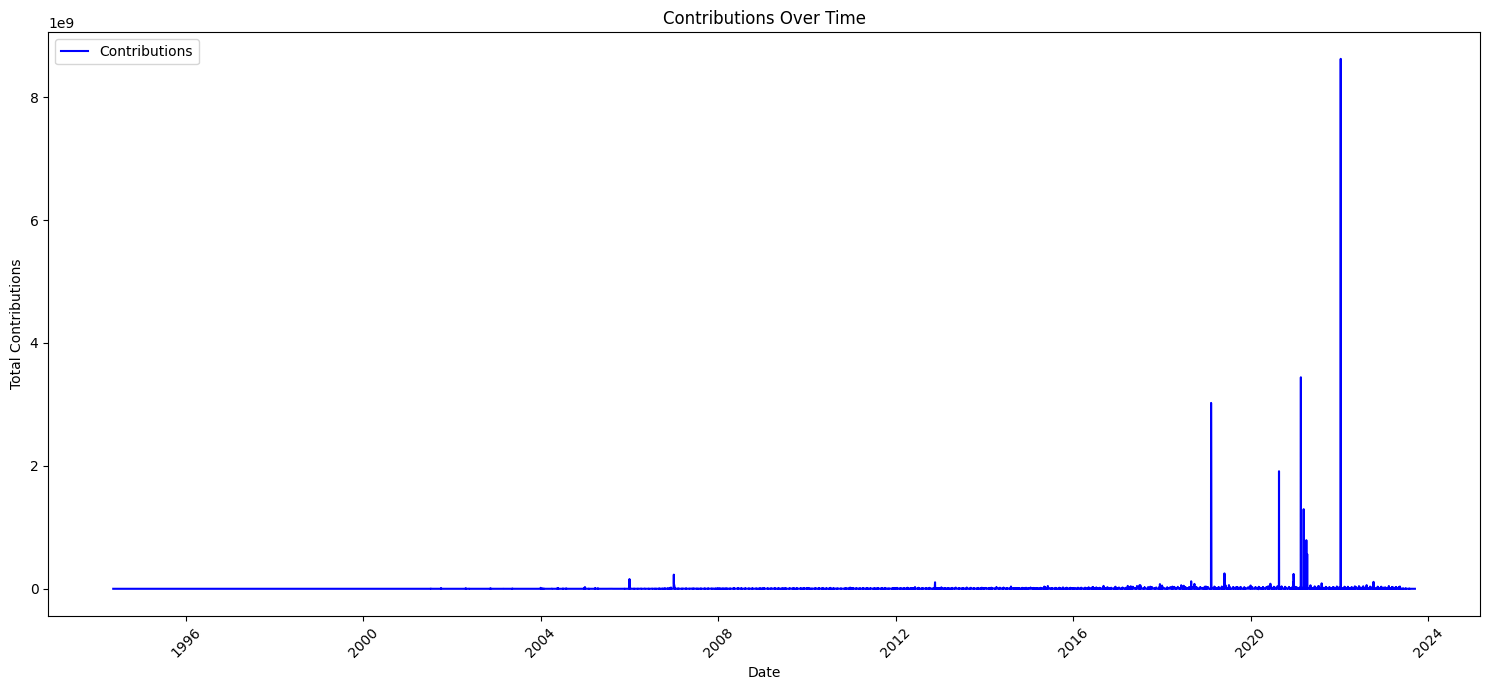

In [4]:
# Отфильтровать данные для операций "Поступление взносов"
contributions = trnsctns[trnsctns['npo_operation_group'] == 0]

# Группировка по дате и суммирование платежей
grouped_contributions = contributions.groupby('npo_operation_date')['npo_sum'].sum()

plt.figure(figsize=(15, 7))

# Построение графика
plt.plot(grouped_contributions.index, grouped_contributions.values, label='Contributions', color='blue')

# Настройка графика
plt.title('Contributions Over Time')
plt.xlabel('Date')
plt.ylabel('Total Contributions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


In [9]:
# Вычисление 99-го квантилей
q99 = trnsctns['npo_sum'].quantile(0.99)

# Отфильтровать платежи, которые превышают 99-й квантиль
high_payments_99 = trnsctns[trnsctns['npo_sum'] > q99]
print(f"Total payments exceeding 99th percentile: {len(high_payments_99)}")

Total payments exceeding 99th percentile: 123249


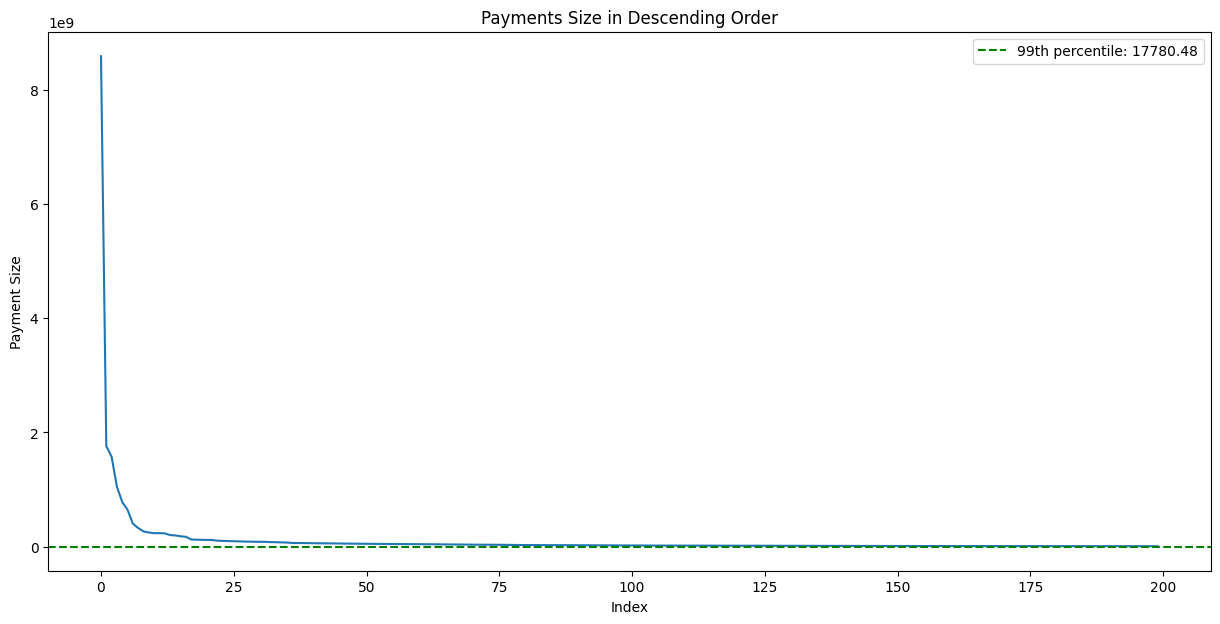

In [10]:
# Сортировка платежей по убыванию
sorted_payments = trnsctns['npo_sum'].sort_values(ascending=False).reset_index(drop=True)
sorted_payments = sorted_payments[0:200]
plt.figure(figsize=(15, 7))
plt.plot(sorted_payments)
plt.axhline(y=q99, color='g', linestyle='--', label=f"99th percentile: {q99:.2f}")
plt.title('Payments Size in Descending Order')
plt.xlabel('Index')
plt.ylabel('Payment Size')
plt.legend()
plt.show()


In [11]:
from sklearn.ensemble import IsolationForest

# Создаем модель
clf = IsolationForest(contamination=0.001)  # contamination - это доля аномалий в данных
outliers = clf.fit_predict(trnsctns[['npo_sum']])
trnsctns['anomaly'] = outliers
anomalies = trnsctns[trnsctns['anomaly'] == -1]



X does not have valid feature names, but IsolationForest was fitted with feature names


In [12]:
trnsctns = trnsctns[trnsctns['anomaly'] == 1]

In [13]:
regions = {
    "Республика Адыгея": [385],
    "Республика Алтай": [649],
    "Алтайский край": list(range(656, 660)),
    "Амурская область": list(range(675, 677)),
    "Архангельская область": list(range(163, 166)),
    "Астраханская область": list(range(414, 417)),
    "Республика Башкортостан": list(range(450, 454)),
    "Белгородская область": list(range(308, 310)),
    "Брянская область": list(range(241, 244)),
    "Республика Бурятия": list(range(670, 672)),
    "Владимирская область": list(range(600, 603)),
    "Волгоградская область": list(range(400, 405)),
    "Вологодская область": list(range(160, 163)),
    "Воронежская область": list(range(394, 398)),
    "Республика Дагестан": list(range(367, 369)),
    "Еврейская автономная область": [679],
    "Забайкальский край": list(range(672, 675)) + [687],
    "Ивановская область": list(range(153, 156)),
    "Республика Ингушетия": [386],
    "Иркутская область": list(range(664, 667)) + [669],
    "Кабардино-Балкарская Республика": list(range(360, 362)),
    "Калининградская область": list(range(236, 239)),
    "Республика Калмыкия": list(range(358, 360)),
    "Калужская область": list(range(248, 250)),
    "Камчатский край": list(range(683, 685)) + [688],
    "Карачаево-Черкесская Республика": [369],
    "Республика Карелия": list(range(185, 187)),
    "Кемеровская область": list(range(650, 655)),
    "Кировская область": list(range(610, 614)),
    "Республика Коми": list(range(167, 170)),
    "Костромская область": list(range(156, 158)),
    "Краснодарский край": list(range(350, 355)),
    "Красноярский край": list(range(660, 664)) + [647, 648],
    "Республика Крым": list(range(295, 299)),
    "Курганская область": list(range(640, 642)),
    "Курская область": list(range(305, 308)),
    "Ленинградская область": list(range(187, 189)),
    "Липецкая область": list(range(398, 400)),
    "Магаданская область": list(range(685, 687)),
    "Республика Марий Эл": list(range(424, 426)),
    "Республика Мордовия": list(range(430, 432)),
    "г. Москва": list(range(101, 136)),
    "Московская область": list(range(140, 145)),
    "Мурманская область": list(range(183, 185)),
    "Ненецкий автономный округ": [166],
    "Нижегородская область": list(range(603, 608)),
    "Новгородская область": list(range(173, 176)),
    "Новосибирская область": list(range(630, 634)),
    "Омская область": list(range(644, 647)),
    "Оренбургская область": list(range(460, 463)),
    "Орловская область": list(range(302, 304)),
    "Пензенская область": list(range(440, 443)),
    "Пермский край": list(range(614, 620)),
    "Приморский край": list(range(690, 693)),
    "Псковская область": list(range(180, 183)),
    "Ростовская область": list(range(344, 348)),
    "Рязанская область": list(range(390, 392)),
    "Самарская область": list(range(443, 447)),
    "г. Санкт-Петербург": list(range(190, 200)),
    "Саратовская область": list(range(410, 414)),
    "Республика Саха (Якутия)": list(range(677, 679)),
    "Сахалинская область": list(range(693, 695)),
    "Свердловская область": list(range(620, 625)),
    "г. Севастополь": [299],
    "Северная Осетия": list(range(362, 364)),
    "Смоленская область": list(range(214, 217)),
    "Ставропольский край": list(range(355, 358)),
    "Тамбовская область": list(range(392, 394)),
    "Республика Татарстан": list(range(420, 424)),
    "Тверская область": list(range(170, 173)),
    "Томская область": list(range(634, 637)),
    "Тульская область": list(range(300, 302)),
    "Республика Тыва (Тува)": list(range(667, 669)),
    "Тюменская область": list(range(625, 628)),
    "Удмуртская Республика": list(range(426, 428)),
    "Ульяновская область": list(range(432, 434)),
    "Хабаровский край": list(range(680, 683)),
    "Республика Хакасия": [655],
    "Ханты-Мансийский автономный округ": [628],
    "Челябинская область": list(range(454, 458)),
    "Чеченская Республика": list(range(364, 367)),
    "Чувашская Республика": list(range(428, 430)),
    "Чукотский автономный округ": [689],
    "Ямало-Ненецкий автономный округ": [629],
    "Ярославская область": list(range(150, 153)),
     "Дополнительные почтовые отделения": [800],
}

In [14]:
# Преобразуем словарь regions так, чтобы каждому индексу соответствовало название региона
index_to_region = {index: region for region, indices in regions.items() for index in indices}

# Преобразуем значения в колонке 'pstl_code' к строковому типу и извлекаем первые 3 символа
clnts['pstl_code3'] = clnts['pstl_code'].astype(str).str.split('.').str[0].str[:3]
#заменяем все что не три цыфры на 800
clnts.loc[~clnts['pstl_code3'].str.match("^\d{3}$"), 'pstl_code3'] = "800"
clnts['pstl_code3'] = clnts['pstl_code3'].fillna(0)
clnts['pstl_code3'] = clnts['pstl_code3'].astype(int)
# Создаем новую колонку 'region', используя словарь index_to_region
clnts['region'] = clnts['pstl_code3'].map(index_to_region)

print(clnts.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230446 entries, 0 to 230445
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clnt_id     230446 non-null  object 
 1   gndr        230442 non-null  float64
 2   slctn_nmbr  230446 non-null  int64  
 3   age         230423 non-null  float64
 4   brth_yr     230423 non-null  float64
 5   pstl_code   220185 non-null  object 
 6   city        230446 non-null  int64  
 7   pstl_code3  230446 non-null  int32  
 8   region      230239 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(3)
memory usage: 14.9+ MB
None


In [15]:
# Отфильтровываем транзакции с типом операции "Поступление взносов"
filtered_trnsctns = trnsctns[trnsctns['npo_operation_group'] == 0]

# Группировка данных по npo_accnt_id и месяцам
grouped_trnsctns = filtered_trnsctns.groupby(['npo_accnt_id', pd.PeriodIndex(filtered_trnsctns['npo_operation_date'], freq='M')])

# Подсчет количества и суммы платежей
monthly_payments = grouped_trnsctns['npo_sum'].agg(['count', 'sum']).reset_index()

# Среднее количество платежей за месяц
avg_payments_per_month = monthly_payments.groupby('npo_accnt_id')['count'].mean().reset_index()
avg_payments_per_month.rename(columns={'count': 'avg_payments_per_month'}, inplace=True)

# Общее количество платежей и средний размер платежа за месяц
total_payments = grouped_trnsctns['npo_sum'].agg(['count', 'mean']).reset_index()
total_payments.rename(columns={'count': 'total_payments', 'mean': 'avg_payment_size'}, inplace=True)

# Объединение данных с cntrbtrs
cntrbtrs = pd.merge(cntrbtrs, avg_payments_per_month, on='npo_accnt_id', how='left')


In [16]:
# Группировка данных по npo_accnt_id для подсчета общего количества платежей
total_payments_count = filtered_trnsctns.groupby('npo_accnt_id')['npo_sum'].count().reset_index()
total_payments_count.rename(columns={'npo_sum': 'total_payments_count'}, inplace=True)

# Объединение данных с cntrbtrs
cntrbtrs = pd.merge(cntrbtrs, total_payments_count, on='npo_accnt_id', how='left')


In [17]:
# Фильтрация данных по типу операции "Поступление взносов"
trnsctns = trnsctns[trnsctns['npo_operation_group'] == 0]

# Преобразование даты операции в формат квартала
trnsctns['quarter'] = pd.to_datetime(trnsctns['npo_operation_date']).dt.to_period('M')

# Группировка данных по npo_accnt_id и кварталу, суммирование сумм операций
quarterly_sums = trnsctns.groupby(['npo_accnt_id', 'quarter'])['npo_sum'].sum().unstack().reset_index()

# Объединение данных с npo_cntrbtrs.csv
cntrbtrs_with_quarterly_sums = pd.merge(cntrbtrs, quarterly_sums, on='npo_accnt_id', how='left')

print(cntrbtrs_with_quarterly_sums.head())



                         npo_accnt_id                             clnt_id  \
0  0x90B7458B8CBFF24980DEC312BA4A1AF5  0x85390230E8955E4FA736E62B0F0E3844   
1  0xC64D3161D31A8441A65224792D370CB3  0xC2B51FD4FE57F7479210FD7258DF5B0B   
2  0xC92F1AA5587E2348BEF17432FBD6C2E6  0x8EC850934FF06A4AA0A856CF43B8D666   
3  0x8DDD2D186B990F43AD5FC9F5C7124E16  0xAF0A0745F8241548B01C4CDA068C51E8   
4  0xA7F12C768A4FB38311E835E81716D8CD  0x943D2C768A4FB38311E65C7B0420641F   

   accnt_pnsn_schm  slctn_nmbr  npo_accnt_status npo_accnt_status_date  \
0              1.0           0                 1            2002-09-13   
1              3.0           2                 0            2020-02-29   
2              4.0           1                 0            2015-05-22   
3              5.0           0                 0            2020-09-28   
4              7.0           3                 1            2008-08-15   

   npo_blnc  npo_pmnts_sum  npo_pmnts_nmbr npo_frst_pmnt_date  ... 2022-12  \
0  10158.96   

In [18]:
for i in cntrbtrs_with_quarterly_sums.columns:
    print(i)


npo_accnt_id
clnt_id
accnt_pnsn_schm
slctn_nmbr
npo_accnt_status
npo_accnt_status_date
npo_blnc
npo_pmnts_sum
npo_pmnts_nmbr
npo_frst_pmnt_date
npo_lst_pmnt_date
npo_ttl_incm
avg_payments_per_month
total_payments_count
1994-05
1994-06
1994-07
1994-08
1994-09
1994-10
1994-11
1994-12
1995-01
1995-02
1995-03
1995-04
1995-05
1995-06
1995-07
1995-08
1995-09
1995-10
1995-11
1995-12
1996-01
1996-02
1996-03
1996-04
1996-05
1996-06
1996-07
1996-08
1996-09
1996-10
1996-11
1996-12
1997-01
1997-02
1997-03
1997-04
1997-05
1997-06
1997-07
1997-08
1997-09
1997-10
1997-11
1997-12
1998-01
1998-02
1998-03
1998-04
1998-05
1998-06
1998-07
1998-08
1998-09
1998-10
1998-11
1998-12
1999-01
1999-02
1999-03
1999-04
1999-05
1999-06
1999-07
1999-08
1999-09
1999-10
1999-11
1999-12
2000-01
2000-02
2000-03
2000-04
2000-05
2000-06
2000-07
2000-08
2000-09
2000-10
2000-11
2000-12
2001-01
2001-02
2001-03
2001-04
2001-05
2001-06
2001-07
2001-08
2001-09
2001-10
2001-11
2001-12
2002-01
2002-02
2002-03
2002-04
2002-05
2002-

In [52]:
# Создание списка месяцев
months = [f"{year}-{month:02}" for year in range(1994, 2024) for month in range(1, 13)]

months_periods = [pd.Period(month, freq='M') for month in months]

# Удаление указанных месяцев из списка (если это необходимо)
# Например, удаление января 1994 и декабря 2023
months_periods = [month for month in months_periods if month not in [pd.Period('1994-01'), pd.Period('1994-02'), pd.Period('1994-03'), pd.Period('1994-04'),
                pd.Period('2023-12'),pd.Period('2023-11'),pd.Period('2023-10')]]
    
def safe_mode(series):
    modes = series.mode()
    if modes.empty:
        return None
    return modes.iloc[0]

aggregations = {
    'npo_accnt_id': 'count',
    'npo_frst_pmnt_date': 'min',
    'npo_lst_pmnt_date': 'max',
    'npo_blnc': 'sum',
    'npo_pmnts_sum': 'sum',
    'npo_pmnts_nmbr': 'sum',
    'npo_ttl_incm': 'sum',
    'npo_accnt_status': lambda x: 1 if any(x == "1") else "0",
    'accnt_pnsn_schm': safe_mode,
    'slctn_nmbr': safe_mode,
    'avg_payments_per_month': 'mean',  # Обновлено для месяцев
    'total_payments_count': 'sum'
}

for month in months_periods:
    aggregations[month] = 'sum'

# Группировка и агрегация
grouped_cntrbtrs = cntrbtrs_with_quarterly_sums.groupby('clnt_id').agg(aggregations).reset_index()  # Обновлено для месяцев

# Объединение с clnts
merged_data = pd.merge(clnts, grouped_cntrbtrs, left_on='clnt_id', right_on='clnt_id', how='left')

# Сохранение результата
merged_data.to_csv('merged_data.csv', index=False)




In [55]:
for i in merged_data.columns:
    print(i)

clnt_id
gndr
slctn_nmbr_x
age
brth_yr
pstl_code
city
pstl_code3
region
npo_accnt_id
npo_frst_pmnt_date
npo_lst_pmnt_date
npo_blnc
npo_pmnts_sum
npo_pmnts_nmbr
npo_ttl_incm
npo_accnt_status
accnt_pnsn_schm
slctn_nmbr_y
avg_payments_per_month
total_payments_count
1994-05
1994-06
1994-07
1994-08
1994-09
1994-10
1994-11
1994-12
1995-01
1995-02
1995-03
1995-04
1995-05
1995-06
1995-07
1995-08
1995-09
1995-10
1995-11
1995-12
1996-01
1996-02
1996-03
1996-04
1996-05
1996-06
1996-07
1996-08
1996-09
1996-10
1996-11
1996-12
1997-01
1997-02
1997-03
1997-04
1997-05
1997-06
1997-07
1997-08
1997-09
1997-10
1997-11
1997-12
1998-01
1998-02
1998-03
1998-04
1998-05
1998-06
1998-07
1998-08
1998-09
1998-10
1998-11
1998-12
1999-01
1999-02
1999-03
1999-04
1999-05
1999-06
1999-07
1999-08
1999-09
1999-10
1999-11
1999-12
2000-01
2000-02
2000-03
2000-04
2000-05
2000-06
2000-07
2000-08
2000-09
2000-10
2000-11
2000-12
2001-01
2001-02
2001-03
2001-04
2001-05
2001-06
2001-07
2001-08
2001-09
2001-10
2001-11
2001-12
20

In [69]:
import pandas as pd

# Создание списка месяцев
months = [pd.Period(f"{year}-{month:02}", freq='M') for year in range(1994, 2024) for month in range(1, 13)]

# Создание нового датафрейма с месяцами в качестве индексов
sums_df = pd.DataFrame(index=months)

# Вычисление суммы для каждого месяца и добавление в новый датафрейм
for month in months:
    if month in merged_data.columns:
        sums_df.loc[month, 'sum'] = merged_data[month].sum()

# Сохранение результата
# sums_df.to_csv('monthly_sums.csv')





In [70]:
sums_df

,sum
1994-01,NaN
1994-02,NaN
1994-03,NaN
1994-04,NaN
1994-05,10373.48
...,...
2023-08,2407322.60
2023-09,211353.43
2023-10,NaN
2023-11,NaN


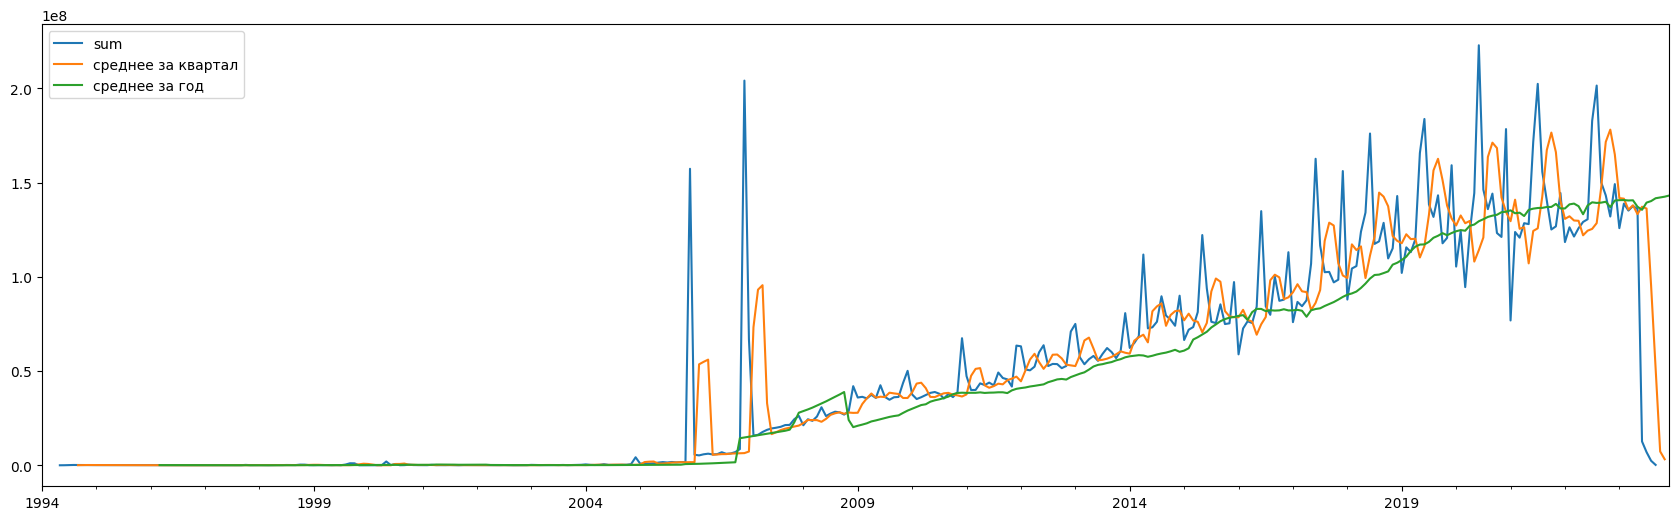

In [75]:
sums_df.plot(figsize = (21,6))
sums_df['sum'].shift(2).rolling(3).mean().plot(label = 'среднее за квартал')
sums_df['sum'].shift(11).rolling(12).mean().plot(label = 'среднее за год')
plt.legend(loc ='upper left');

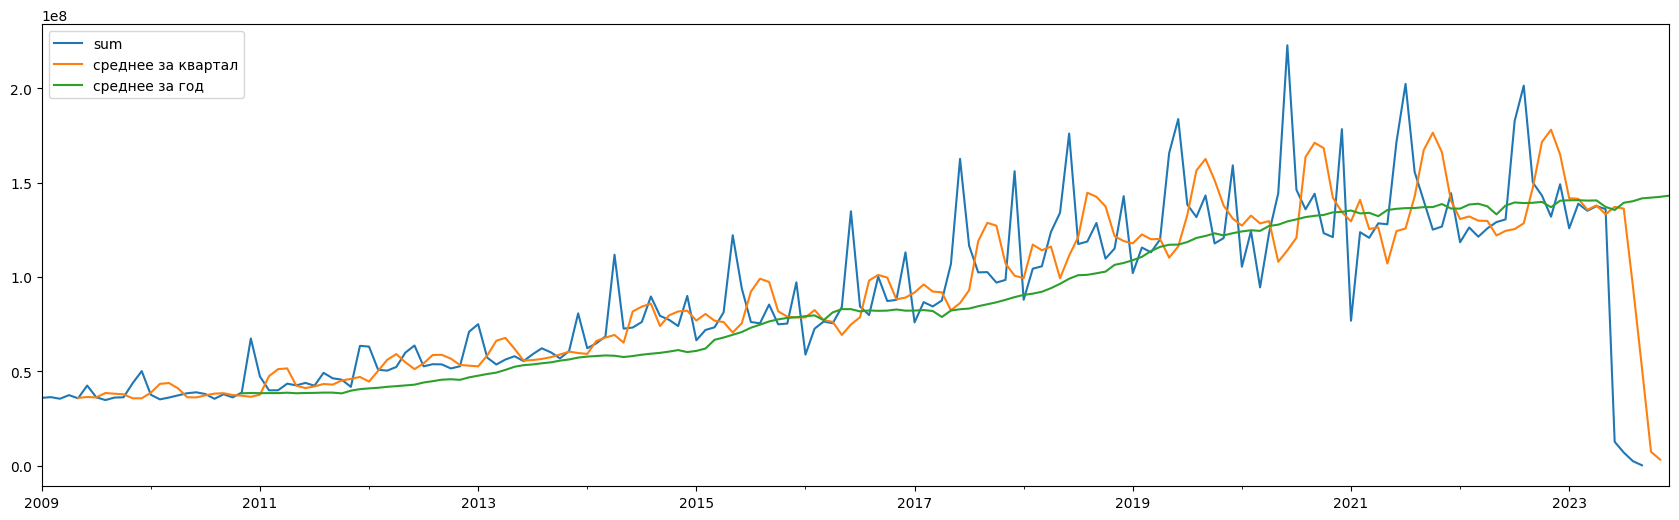

In [76]:
sums_df = sums_df[sums_df.index >= pd.Period('2009-01', freq='M')]
sums_df.plot(figsize = (21,6))
sums_df['sum'].shift(2).rolling(3).mean().plot(label = 'среднее за квартал')
sums_df['sum'].shift(11).rolling(12).mean().plot(label = 'среднее за год')
plt.legend(loc ='upper left');


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


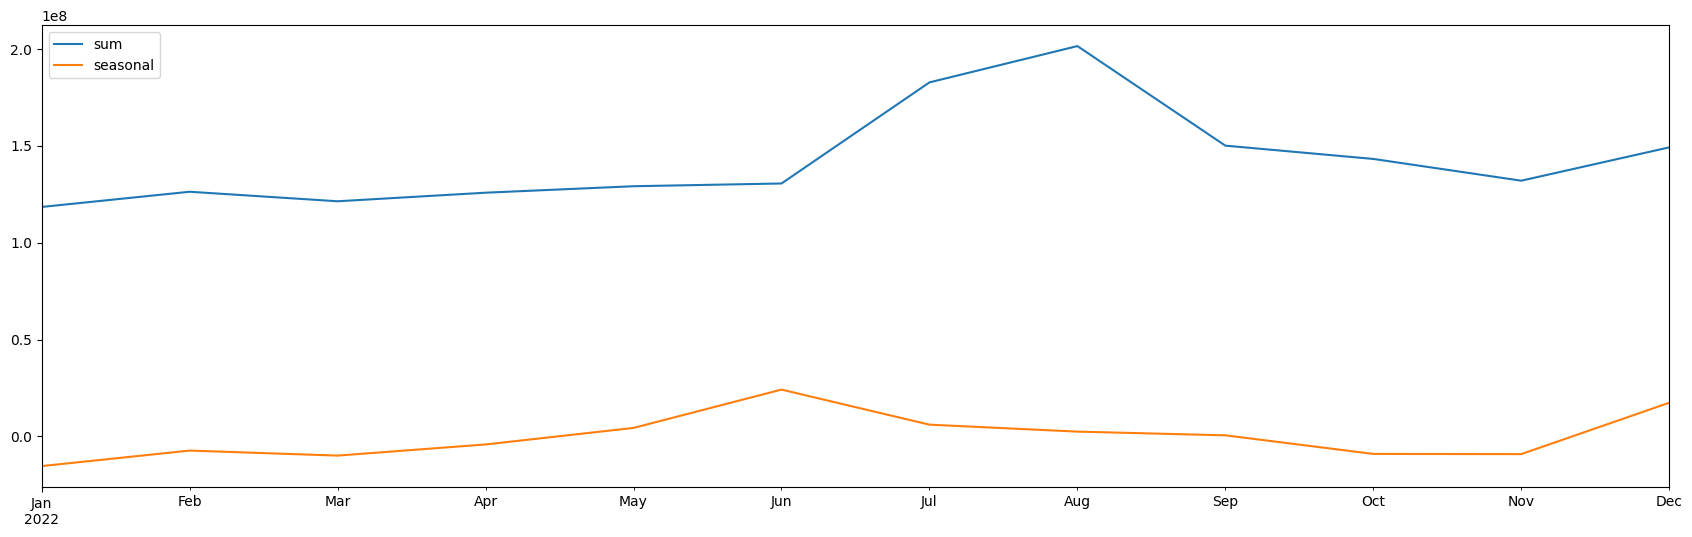

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
sums_df.dropna(inplace=True)

decomposed = seasonal_decompose(sums_df, period=12)

sums_df['2022-01-01':'2022-12-31'].plot()
decomposed.seasonal['2022-01-01':'2022-12-31'].plot(figsize = (21,6))
plt.legend(loc ='upper left');

In [85]:
def make_features(data, max_lag, rolling_mean_size1, rolling_mean_size2):
    data['month'] = data.index.month
    data['year'] = data.index.year
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['sum'].shift(lag)
    data['rolling_mean_{}'.format(rolling_mean_size1)] = (
         data['sum'].shift(rolling_mean_size1-1).rolling(rolling_mean_size1).mean()
    )
        
    data['rolling_mean_{}'.format(rolling_mean_size2)] = (
         data['sum'].shift(rolling_mean_size2-1).rolling(rolling_mean_size2).mean()
    )

make_features(sums_df, 12, 5, 24)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [86]:
sums_df

,sum,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_5,rolling_mean_24
2009-01,3.595370e+07,1,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02,3.633061e+07,2,2009,3.595370e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03,3.548025e+07,3,2009,3.633061e+07,3.595370e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04,3.738465e+07,4,2009,3.548025e+07,3.633061e+07,3.595370e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05,3.570608e+07,5,2009,3.738465e+07,3.548025e+07,3.633061e+07,3.595370e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,1.360194e+08,5,2023,1.375697e+08,1.351297e+08,1.388463e+08,1.258201e+08,1.491770e+08,1.319811e+08,1.432093e+08,1.500705e+08,2.014630e+08,1.827168e+08,1.305415e+08,1.291210e+08,1.400516e+08,1.343507e+08
2023-06,1.265984e+07,6,2023,1.360194e+08,1.375697e+08,1.351297e+08,1.388463e+08,1.258201e+08,1.491770e+08,1.319811e+08,1.432093e+08,1.500705e+08,2.014630e+08,1.827168e+08,1.305415e+08,1.378068e+08,1.370164e+08
2023-07,6.981638e+06,7,2023,1.265984e+07,1.360194e+08,1.375697e+08,1.351297e+08,1.388463e+08,1.258201e+08,1.491770e+08,1.319811e+08,1.432093e+08,1.500705e+08,2.014630e+08,1.827168e+08,1.361908e+08,1.380132e+08
2023-08,2.407323e+06,8,2023,6.981638e+06,1.265984e+07,1.360194e+08,1.375697e+08,1.351297e+08,1.388463e+08,1.258201e+08,1.491770e+08,1.319811e+08,1.432093e+08,1.500705e+08,2.014630e+08,1.373086e+08,1.378919e+08


In [102]:

econ = pd.read_excel('dop/econ.xlsx')

In [103]:
econ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       365 non-null    datetime64[ns]
 1   dollar     365 non-null    float64       
 2   CB         365 non-null    float64       
 3   var        365 non-null    int64         
 4   petrol     365 non-null    float64       
 5   inflation  365 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 17.2 KB


In [105]:
import pandas as pd

# Изменяем частоту на 'MS' для начала месяца
econ2 = pd.DataFrame({
    'date': pd.date_range(start='2009-01-01', end='2022-12-01', freq='MS')
})

# Данные, которые вы предоставили
data = {
    'date': [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'dohod': [1927681, 1927681, 1927681, 1927681, 1927681, 2087267, 2357163, 2403312, 2478739, 2581482, 2734467, 2813636, 3083305, 3494797],
    'nasel': [143201.7, 143201.7, 143201.7, 143201.7, 143347.1, 146090.6, 146267.3, 146674.5, 146804.4, 145548.8, 143107.6, 146748.9, 144501.4, 143972.5],
    'no_job': [6283.9, 5544.7, 4922.6, 4131.3, 4137.4, 3889.7, 4263.8, 4243.8, 3967, 3657.1, 3461, 4316, 3624.2, 2948.2],
    'job': [75694, 75478, 75779, 75676, 75529, 75429, 76588, 76636, 76109, 76011, 75225, 74777, 75222, 74809],
    'vvp': [91813368579, 89389135231, 87028911161, 84731006271, 82493775090, 80315615595, 78194968061, 76130313947, 74120174806, 75534248609, 77582840430, 78817114968, 77336148469, 83034260416]
}

# Создаем новый датафрейм из вашего списка
yearly_df = pd.DataFrame(data)

# Преобразуем столбец date в формат datetime для yearly_df
yearly_df['date'] = pd.to_datetime(yearly_df['date'], format='%Y')

# Распространяем значения на все месяцы
for index, row in yearly_df.iterrows():
    mask = (econ2['date'].dt.year == row['date'].year)
    for column in yearly_df.columns:
        if column != 'date':
            econ2.loc[mask, column] = row[column]

print(econ2)



          date      dohod     nasel  no_job      job           vvp
0   2009-01-01  1927681.0  143201.7  6283.9  75694.0  9.181337e+10
1   2009-02-01  1927681.0  143201.7  6283.9  75694.0  9.181337e+10
2   2009-03-01  1927681.0  143201.7  6283.9  75694.0  9.181337e+10
3   2009-04-01  1927681.0  143201.7  6283.9  75694.0  9.181337e+10
4   2009-05-01  1927681.0  143201.7  6283.9  75694.0  9.181337e+10
..         ...        ...       ...     ...      ...           ...
163 2022-08-01  3494797.0  143972.5  2948.2  74809.0  8.303426e+10
164 2022-09-01  3494797.0  143972.5  2948.2  74809.0  8.303426e+10
165 2022-10-01  3494797.0  143972.5  2948.2  74809.0  8.303426e+10
166 2022-11-01  3494797.0  143972.5  2948.2  74809.0  8.303426e+10
167 2022-12-01  3494797.0  143972.5  2948.2  74809.0  8.303426e+10

[168 rows x 6 columns]


In [108]:
result = pd.merge(econ, econ2, on='date', how='left')
result.fillna(0, inplace=True)


In [110]:
# Преобразование индекса в столбец
sums_df = sums_df.reset_index()

# Преобразование типа данных столбца из "период" в "дата"
sums_df['index'] = sums_df['index'].dt.to_timestamp()

# Объединение датафреймов
final_result = pd.merge(result, sums_df, left_on='date', right_on='index', how='left').drop(columns=['index'])


In [155]:
final_result = final_result[final_result['date'] >= '2009-01-01']
final_result.index = pd.to_datetime(final_result['date'])


In [156]:
train, test = train_test_split(final_result, shuffle=False, test_size=0.2)


X_train = train.drop('sum', axis=1)
y_train = train['sum']
X_test = test.drop('sum', axis=1)
y_test = test['sum']

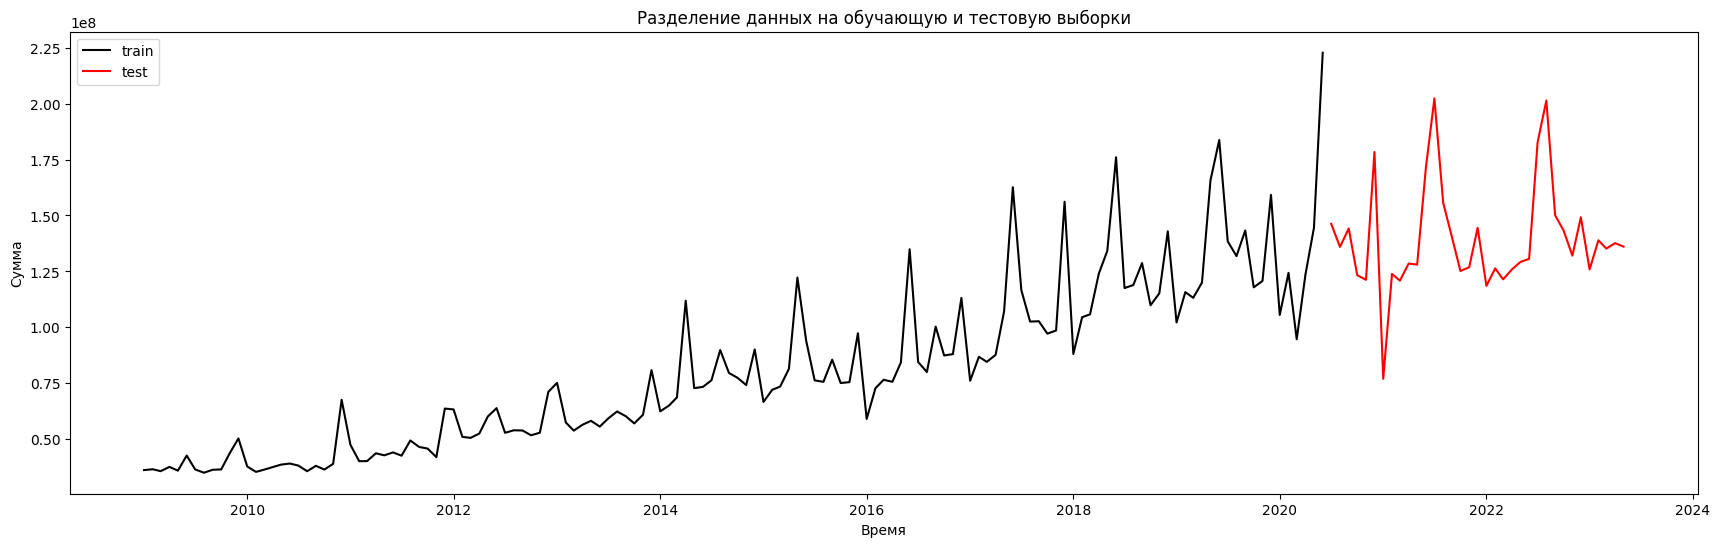

In [157]:
plt.figure(figsize = (21,6))
plt.plot(y_train, color = "black", label = 'train')
plt.plot(y_test, color = "red", label = 'test')
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Сумма')
plt.xlabel('Время')
plt.legend(loc ='upper left')
plt.show()

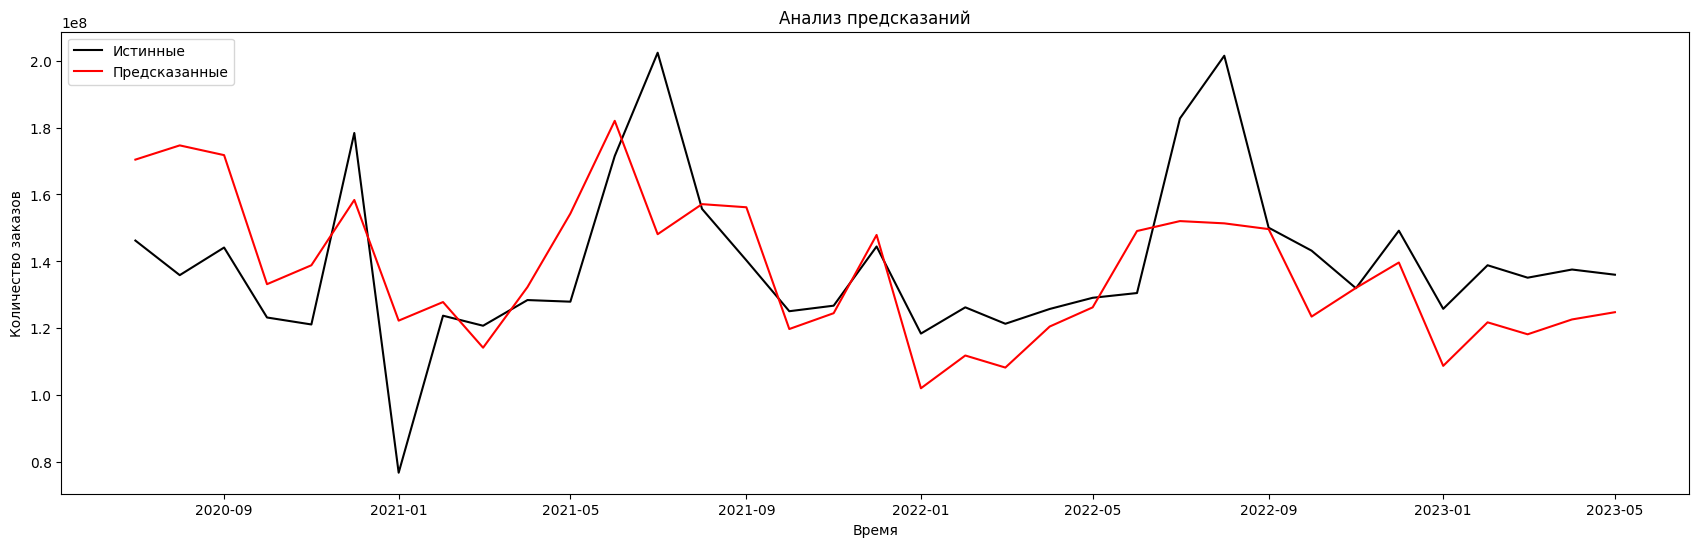

RMSE: 21394160.093535334
MAE: 16448624.494386608


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

model_CatBoostRegressor = CatBoostRegressor(verbose=0)  # отключим вывод прогресса обучения
model_CatBoostRegressor.fit(X_train, y_train)
y_pred = model_CatBoostRegressor.predict(X_test)

fh = y_test.index
y_pred_series = pd.Series(y_pred, index=fh)

plt.figure(figsize=(21, 6))
plt.plot(y_test, color="black", label='Истинные')
plt.plot(y_pred_series, color="red", label='Предсказанные')
plt.title('Анализ предсказаний')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.legend(loc='upper left')
plt.show()

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))


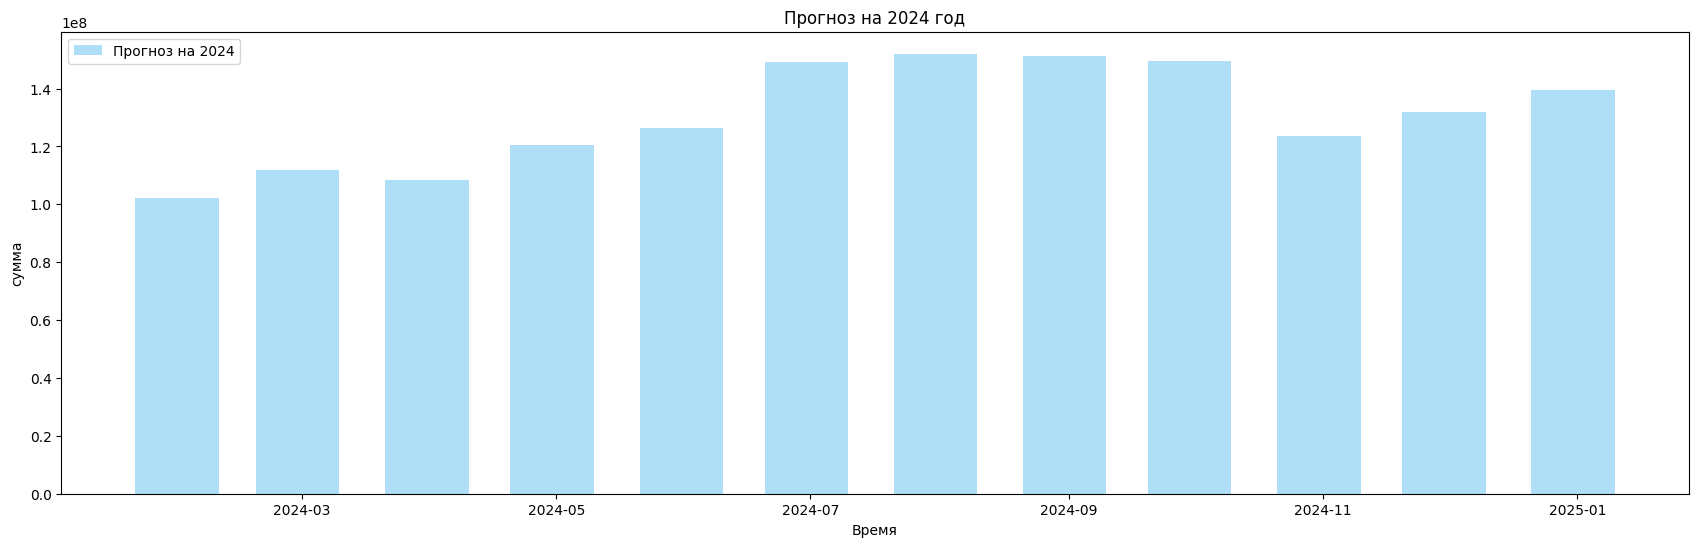

Прогнозируемая сумма на 2024 год: 1566389588.24 рублей


In [166]:
# Выбор данных за 2022 год
data_2022 = X_test['2022-01-01':'2022-12-31'].copy()

# Изменение индекса на 2024 год
data_2022.index = pd.date_range(start='2024-01-01', end='2024-12-31', freq='M')

# Предсказание на 2024 год
forecast_2024 = model_CatBoostRegressor.predict(data_2022)

# Визуализация результатов
plt.figure(figsize=(21, 6))
plt.bar(data_2022.index, forecast_2024, color="#AEDFF7", width=20, label='Прогноз на 2024')  # Пастельный голубой цвет и широкие столбцы
plt.title('Прогноз на 2024 год')
plt.ylabel('сумма')
plt.xlabel('Время')
plt.legend(loc='upper left')
plt.show()

total_forecast_2024 = forecast_2024.sum()
print(f"Прогнозируемая сумма на 2024 год: {total_forecast_2024:.2f} рублей")



In [150]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_CatBoostRegressor)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

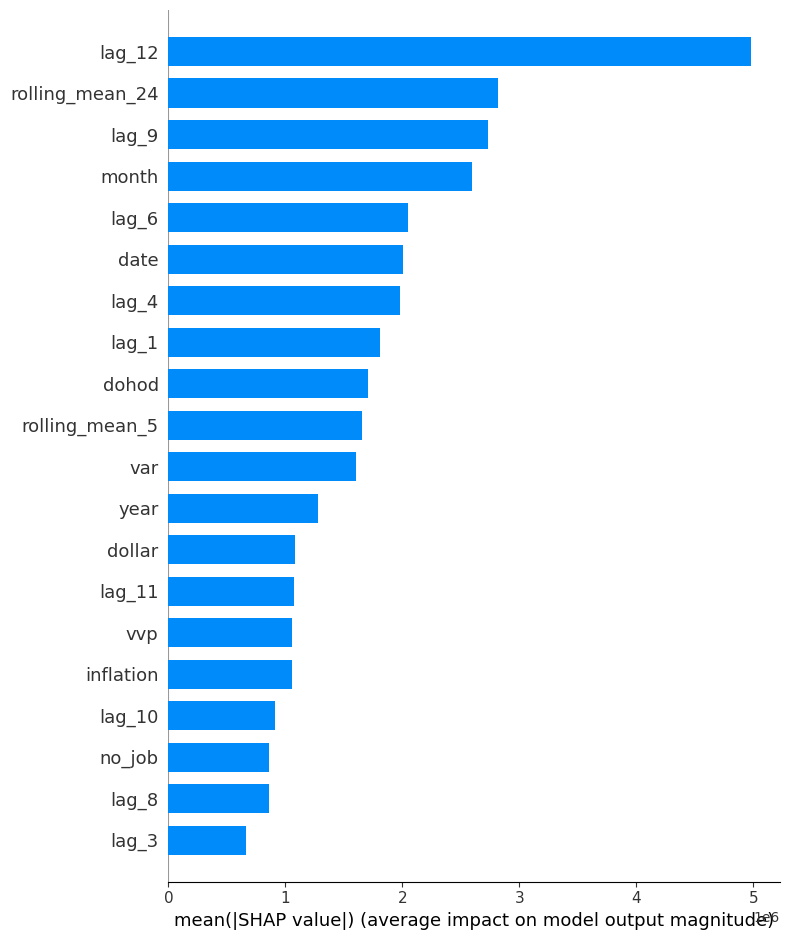

In [151]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


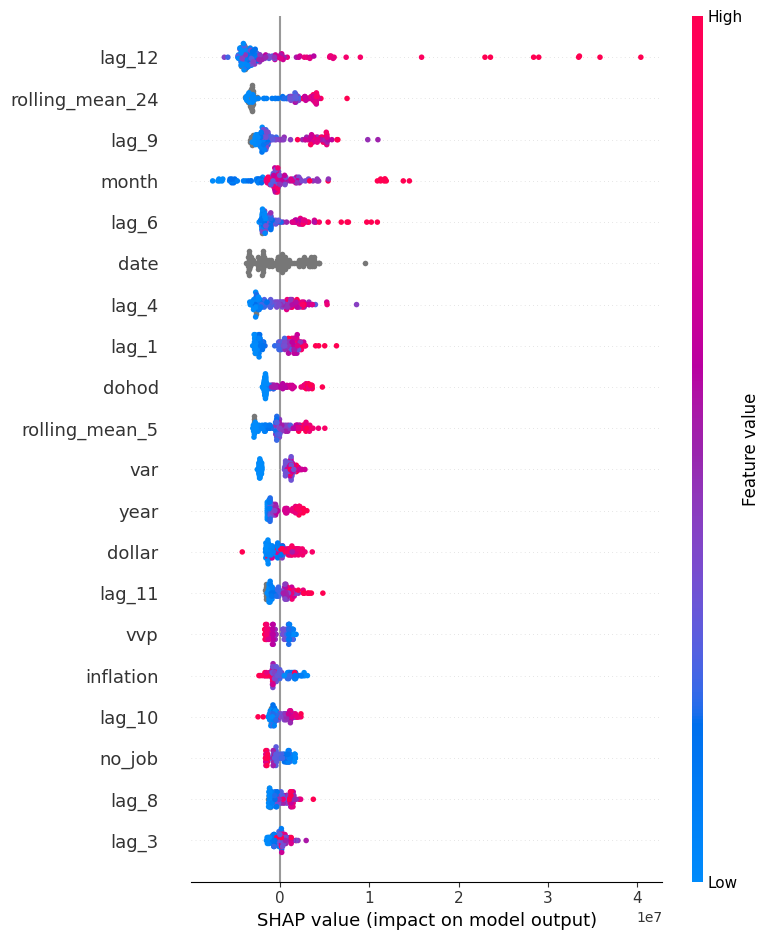

In [152]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)